<a href="https://colab.research.google.com/github/luctiz/Grupo43-TP2/blob/master/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Carga y limpieza de datos

## (Hecho con la info obtenida en el notebook LimpiezaDeDatos)

In [0]:
#import io
#ruta = io.StringIO(uploaded['train.csv'].decode('utf-8'))
ejemplo = pd.read_csv("../content/drive/My Drive/data/ejemploRespuesta.csv", names = ["id", "precio"])
test = pd.read_csv("../content/drive/My Drive/data/test.csv", parse_dates = ['fecha'])
train = pd.read_csv("../content/drive/My Drive/data/train.csv",parse_dates = ['fecha'])
#ejemplo =  pd.read_csv('data/ejemploRespuesta.csv', names = ["id", "precio"] )
#test =  pd.read_csv('data/test.csv', parse_dates = ['fecha'])
#train = pd.read_csv('data/train.csv',parse_dates = ['fecha'])

In [0]:
 (test.provincia.isnull() & test.ciudad.isnull()).sum()

42

In [0]:
#El precio promedio de las publicaciones que no tienen datos de cant de habitaciones esta entre el precio
#promedio de las que tienen 2 y 3 habitaciones
#Entonces voy a asumir que tienen 3 habitaciones, ya que es el valor al cual el precio mas se les asemeja.
train['habitaciones']=train['habitaciones'].fillna(3)
test['habitaciones']=test['habitaciones'].fillna(3)
#Luego convierto a np.int8
train['habitaciones']=train['habitaciones'].astype(np.int8)
test['habitaciones']=test['habitaciones'].astype(np.int8)

In [0]:
#Creo categoria para los que no tienen categoria en provincia:
train['provincia']=train['provincia'].fillna('N/A')
test['provincia']=test['provincia'].fillna('N/A')
#Creo categoria para los que no tienen categoria en ciudad:
train['ciudad']=train['ciudad'].fillna('N/A')
test['ciudad']=test['ciudad'].fillna('N/A')
#Relleno los nulls en direccion con un - .
train['direccion']=train['direccion'].fillna('-')
test['direccion']=test['direccion'].fillna('-')
#Creo categoria para los que no tienen categoria en tipodepropiedad:
train['tipodepropiedad']=train['tipodepropiedad'].fillna('N/A')
test['tipodepropiedad']=test['tipodepropiedad'].fillna('N/A')

In [0]:
train['metroscubiertos']=train.metroscubiertos.fillna(round(train.metroscubiertos.mean()))
test['metroscubiertos']=test.metroscubiertos.fillna(round(train.metroscubiertos.mean()))
#Luego convierto metroscubiertos a  np.int16
train['metroscubiertos']=train['metroscubiertos'].astype(np.int16)
test['metroscubiertos']=test['metroscubiertos'].astype(np.int16)

#del aux_means # lo borro ya que no lo uso mas



In [0]:
#A los nulls los relleno con el promedio de metrostotales de todas las publicaciones en train
train['metrostotales']=train['metrostotales'].fillna(round(train['metrostotales'].mean()))
test['metrostotales']=test['metrostotales'].fillna(round(train['metrostotales'].mean()))
#Luego convierto metrostotales a  np.int16
train['metrostotales']=train['metrostotales'].astype(np.int16)
test['metrostotales']=test['metrostotales'].astype(np.int16)

In [0]:
#A los que no tienen datos de antiguedad los relleno con la antiguedad promedio (es 8)
train['antiguedad']=train['antiguedad'].fillna(round(train['antiguedad'].mean()))
test['antiguedad']=test['antiguedad'].fillna(round(train['antiguedad'].mean()))
#Luego convierto a np.uint8
train['antiguedad']=train['antiguedad'].astype(np.uint8)
test['antiguedad']=test['antiguedad'].astype(np.uint8)

In [0]:
#El precio promedio de los que tienen NULL en garage es parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['garages']=train['garages'].fillna(2)
test['garages']=test['garages'].fillna(2)
#convierto a np.int8
train['garages']=train['garages'].astype(np.int8)
test['garages']=test['garages'].astype(np.int8)

In [0]:
#El precio promedio de los que tienen NULL en banos es mas parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['banos']=train['banos'].fillna(2)
test['banos']=test['banos'].fillna(2)
#convierto a np.int8
train['banos']=train['banos'].astype(np.int8)
test['banos']=test['banos'].astype(np.int8)

In [0]:
train['gimnasio']=train['gimnasio'].astype(np.int8)
train['usosmultiples']=train['usosmultiples'].astype(np.int8)
train['piscina']=train['piscina'].astype(np.int8)
train['escuelascercanas']=train['escuelascercanas'].astype(np.int8)
train['centroscomercialescercanos']=train['centroscomercialescercanos'].astype(np.int8)
test['gimnasio']=test['gimnasio'].astype(np.int8)
test['usosmultiples']=test['usosmultiples'].astype(np.int8)
test['piscina']=test['piscina'].astype(np.int8)
test['escuelascercanas']=test['escuelascercanas'].astype(np.int8)
test['centroscomercialescercanos']=test['centroscomercialescercanos'].astype(np.int8)

In [0]:
train['titulo']=train['titulo'].fillna(' ')
train['descripcion']=train['descripcion'].fillna(' ')
test['titulo']=test['titulo'].fillna(' ')
test['descripcion']=test['descripcion'].fillna(' ')

In [0]:
train['precio']=train['precio'].astype(np.int32)
train['id']=train['id'].astype(np.int32)
test['id']=test['id'].astype(np.int32)

In [0]:
aux_glng=train.groupby('provincia')['lng'].mean()
aux_glat=train.groupby('provincia')['lng'].mean()

In [0]:
train.lat=train.lat.fillna(train.lat.mean())
train.lng=train.lng.fillna(train.lng.mean())
test.lat=test.lat.fillna(train.lat.mean())
test.lng=test.lng.fillna(train.lng.mean())

In [0]:
#Algunas columnas tienen nulls que no se como encararlos. Por ahora los relleno con 0
train=train.fillna(0)
test=test.fillna(0)

# Armado de features:

In [0]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [0]:
test.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos'],
      dtype='object')

## Features sobre el tiempo

En el TP1 vimos como los precios iban en aumento a medida que el tiempo aumentaba, por lo que nos interesa crear nuevos features tomando en cuenta el tiempo en el que se publicaron las propiedades.


Para realizar un nuevo feature comenzaremos añadiendo un peso para cada fecha, este peso irá en aumento a medida que las fechas van subiendo, así simularemos el crecimiento del precio a lo largo del tiempo.

In [0]:
#Califico las fechas de acuerdo a la diferencia entre la fecha actual y la fecha mínima sobre el máximo de dias
fecha_min = train.fecha.min()
fecha_max = train.fecha.max()
delta_max_days = (fecha_max - fecha_min).days
def calificar_fecha(fecha):
    delta = fecha - fecha_min
    return delta.days/delta_max_days

In [0]:
train["puntaje_por_fecha"] = train['fecha'].transform(lambda x: calificar_fecha(x))
train.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,puntaje_por_fecha
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,20.696818,-99.509221,2015-08-23,0,0,0,0,0,2273000,0.728368


In [0]:
#Set de test
test["puntaje_por_fecha"] = test['fecha'].transform(lambda x: calificar_fecha(x))
test.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,puntaje_por_fecha
0,4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29,3,2,4,300,177,0.0,19.408668,-99.246767,2013-07-20,0,0,0,0,0,0.309967


## Features descripcion

Para el primer TP descubrimos que habia ciertas palabras que estaban correlacionadas a mayor precio y otras a menor precio. Usando esa informacion vamos a armar features que nos digan si la descripcion tiene o no determinada palabra

In [0]:
#Paso todas las descripciones a minúscula para contar las palabras con mas precision
train['descripcion']=train['descripcion'].apply(lambda x: x.lower())

In [0]:
Palabras_mayor_precio=['cuarto','vestidor','terraza','family','vista','bodega',\
                       'salón','estudio','jardín','room','jacuzzi','lujo','antecomedor',\
                       'tv','fiestas','juegos','estacionamiento','gimnasio','nado',\
                       'lugares','doble','desayunador','servicio','chimenea','visita',\
                       'acabado','espacio','salon','alberca','garden','spa']
Palabras_menor_precio=['minutos','acept','boiler','reja','credito','transporte'\
                      ,'cochera','contado','escuela','inf','fovissste','cerca',\
                      'bancario','protecciones','patio','infonavit']
Palabras=Palabras_mayor_precio + Palabras_menor_precio

In [0]:
dummies_palabras_descr=pd.DataFrame()
#Por cada palabra en la lista genero una columna que diga si la descripcion contenia esa palabra o no
for palabra in Palabras:
    dummies_palabras_descr[palabra]=train['descripcion'].apply(lambda x: palabra in x).astype(np.int8)
#Renombro estas columnas agregandoles un prefijo
dummies_palabras_descr=dummies_palabras_descr.add_prefix('desc_')

In [0]:
dummies_palabras_descr.head(3)

,desc_cuarto,desc_vestidor,desc_terraza,desc_family,desc_vista,desc_bodega,desc_salón,desc_estudio,desc_jardín,desc_room,desc_jacuzzi,desc_lujo,desc_antecomedor,desc_tv,desc_fiestas,desc_juegos,desc_estacionamiento,desc_gimnasio,desc_nado,desc_lugares,desc_doble,desc_desayunador,desc_servicio,desc_chimenea,desc_visita,desc_acabado,desc_espacio,desc_salon,desc_alberca,desc_garden,desc_spa,desc_minutos,desc_acept,desc_boiler,desc_reja,desc_credito,desc_transporte,desc_cochera,desc_contado,desc_escuela,desc_inf,desc_fovissste,desc_cerca,desc_bancario,desc_protecciones,desc_patio,desc_infonavit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0


In [0]:
dummies_palabras_descr_test=pd.DataFrame()
#Hago lo mismo para el set de test
for palabra in Palabras:
    dummies_palabras_descr_test[palabra]=test['descripcion'].apply(lambda x: palabra in x).astype(np.int8)
dummies_palabras_descr_test=dummies_palabras_descr_test.add_prefix('desc_')

In [0]:
dummies_palabras_descr_test.head()

,desc_cuarto,desc_vestidor,desc_terraza,desc_family,desc_vista,desc_bodega,desc_salón,desc_estudio,desc_jardín,desc_room,desc_jacuzzi,desc_lujo,desc_antecomedor,desc_tv,desc_fiestas,desc_juegos,desc_estacionamiento,desc_gimnasio,desc_nado,desc_lugares,desc_doble,desc_desayunador,desc_servicio,desc_chimenea,desc_visita,desc_acabado,desc_espacio,desc_salon,desc_alberca,desc_garden,desc_spa,desc_minutos,desc_acept,desc_boiler,desc_reja,desc_credito,desc_transporte,desc_cochera,desc_contado,desc_escuela,desc_inf,desc_fovissste,desc_cerca,desc_bancario,desc_protecciones,desc_patio,desc_infonavit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


## Features titulo

Mismo procedimiento anterior pero para palabras que encontramos correlacionadas a mayor o menor precio en 'titulo'

In [0]:
#Paso todas los titulos a minúscula para contar las palabras con mas precision
train['titulo']=train['titulo'].apply(lambda x: x.lower())

In [0]:
Palabras_mayor_precio=['polanco','loma','herradura','condesa','bosque','country',\
                       'hermosa','vista','residencia','condominio','golf','lujo','huixquilucan',\
                      ]
Palabras_menor_precio=['terreno','fracc','casa','villa','remate','recamaras'\
                      ,'ecatepec','cerca','coacalco','izcalli','planta','lote',\
                      'bonita','cautitlan']
Palabras=Palabras_mayor_precio + Palabras_menor_precio

In [0]:
dummies_palabras_titulo=pd.DataFrame()
#Por cada palabra en la lista genero una columna que diga si la descripcion contenia esa palabra o no
for palabra in Palabras:
    dummies_palabras_titulo[palabra]=train['titulo'].apply(lambda x: palabra in x).astype(np.int8)
#Renombro estas columnas agregandoles un prefijo
dummies_palabras_titulo=dummies_palabras_titulo.add_prefix('titl_')

In [0]:
dummies_palabras_titulo.head(3)

,titl_polanco,titl_loma,titl_herradura,titl_condesa,titl_bosque,titl_country,titl_hermosa,titl_vista,titl_residencia,titl_condominio,titl_golf,titl_lujo,titl_huixquilucan,titl_terreno,titl_fracc,titl_casa,titl_villa,titl_remate,titl_recamaras,titl_ecatepec,titl_cerca,titl_coacalco,titl_izcalli,titl_planta,titl_lote,titl_bonita,titl_cautitlan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [0]:
dummies_palabras_titulo_test=pd.DataFrame()
#Hago lo mismo para el set de test
for palabra in Palabras:
    dummies_palabras_titulo_test[palabra]=test['titulo'].apply(lambda x: palabra in x).astype(np.int8)
dummies_palabras_titulo_test=dummies_palabras_titulo_test.add_prefix('titl_')

In [0]:
dummies_palabras_titulo_test.head(3)

,titl_polanco,titl_loma,titl_herradura,titl_condesa,titl_bosque,titl_country,titl_hermosa,titl_vista,titl_residencia,titl_condominio,titl_golf,titl_lujo,titl_huixquilucan,titl_terreno,titl_fracc,titl_casa,titl_villa,titl_remate,titl_recamaras,titl_ecatepec,titl_cerca,titl_coacalco,titl_izcalli,titl_planta,titl_lote,titl_bonita,titl_cautitlan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Agrego más features basados en las fechas

In [0]:
train['dia'] = train['fecha'].dt.day
train['mes'] = train['fecha'].dt.month
train['año'] = train['fecha'].dt.year
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,puntaje_por_fecha,dia,mes,año
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,20.696818,-99.509221,2015-08-23,0,0,0,0,0,2273000,0.728368,23,8,2015
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10,3,2,2,268,180,24514.0,19.310205,-99.227655,2013-06-28,0,0,0,1,1,3600000,0.297919,28,6,2013
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5,3,2,2,144,166,48551.0,20.696818,-99.509221,2015-10-17,0,0,0,0,0,1200000,0.758488,17,10,2015
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1,2,1,1,63,67,53666.0,19.301890,-99.688015,2012-03-09,0,0,0,1,1,650000,0.037240,9,3,2012
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10,2,1,1,95,95,47835.0,20.696818,-99.509221,2016-06-07,0,0,0,0,0,1150000,0.886637,7,6,2016


In [0]:
test['dia'] = test['fecha'].dt.day
test['mes'] = test['fecha'].dt.month
test['año'] = test['fecha'].dt.year
test.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,puntaje_por_fecha,dia,mes,año
0,4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29,3,2,4,300,177,0.0,19.408668,-99.246767,2013-07-20,0,0,0,0,0,0.309967,20,7,2013
1,51775,departamentos en venta en montebello,<p>departamento una recamara:\n</p><p>departam...,Apartamento,-,Mérida,Yucatán,8,1,1,1,67,67,113851.0,21.032480,-89.592424,2015-10-24,0,0,0,0,0,0.762322,24,10,2015
2,115253,departamento nuevo delegación coyoacán de 87 m...,"departamento nuevo de 87.06 m2, 1 cajón de est...",Apartamento,"Pueblo de los Reyes, Coyoacán, Mexico D.F.",Coyoacán,Distrito Federal,0,2,1,2,87,100,23620.0,19.332829,-99.152913,2015-05-30,0,0,0,0,1,0.681818,30,5,2015
3,299321,departamento en venta en acapulco,<p> raíces dv001 precioso departamento tipo k...,Apartamento,-,Acapulco de Juárez,Guerrero,2,2,2,2,86,86,129347.0,16.860487,-99.878383,2015-04-02,0,0,0,0,0,0.650055,2,4,2015
4,173570,bonita casa sola equipada de dos niveles en lo...,"<p>casa sola, bonita de dos rec&aacute;maras u...",Casa,CEDROS,Tultitlán,Edo. de México,10,2,1,1,80,76,57125.0,19.640482,-99.127273,2013-08-15,0,0,0,1,1,0.324206,15,8,2013


## Agrego features sobre la cantidad de publicaciones

Como hemos visto en el tp1 la cantidad de publicaciones y el precio se comportan igual a través del tiempo, por lo que podríamos estimar el mismo a través de este feature

In [0]:
train['publicaciones_por_mes'] = train[['año','mes', 'id']].groupby(['año','mes']).transform(lambda x: x.count())
train['publicaciones_por_mes'] = train['publicaciones_por_mes'].fillna(0)
train.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,puntaje_por_fecha,dia,mes,año,publicaciones_por_mes
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,20.696818,-99.509221,2015-08-23,0,0,0,0,0,2273000,0.728368,23,8,2015,4526


In [0]:
test['publicaciones_por_mes'] = test[['año','mes', 'id']].groupby(['año','mes']).transform(lambda x: x.count())
test['publicaciones_por_mes'] = test['publicaciones_por_mes'].fillna(0)
test.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,puntaje_por_fecha,dia,mes,año,publicaciones_por_mes
0,4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29,3,2,4,300,177,0.0,19.408668,-99.246767,2013-07-20,0,0,0,0,0,0.309967,20,7,2013,650


In [0]:
train['publicaciones_por_dia'] = train[['dia','año','mes', 'id']].groupby(['dia','año','mes']).transform(lambda x: x.count()).fillna(0)
test['publicaciones_por_dia'] = test[['dia','año','mes', 'id']].groupby(['dia','año','mes']).transform(lambda x: x.count()).fillna(0)

In [0]:
train['publicaciones_por_año'] = train[['año','id']].groupby(['año']).transform(lambda x: x.count()).fillna(0)
test['publicaciones_por_año'] = test[['año','id']].groupby(['año']).transform(lambda x: x.count()).fillna(0)

## Pruebo target encoder en lugar de oneHotEncoder para tipodepropiedad, ciudades, provincias y agrego idzona

**Primero voy a unificar los dummies sobre palabras**

In [0]:
dummies_palabras=dummies_palabras_descr.join(dummies_palabras_titulo)
dummies_palabras_test=dummies_palabras_descr_test.join(dummies_palabras_titulo_test)

**Voy a usar la cantidad de publicaciones por año como target, pues hemos visto que la cantidad de publicaciones aumentaba en el tiempo, al igual que el precio de las propiedades**

In [0]:
!pip install category_encoders

In [0]:
import category_encoders as ce
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['publicaciones_por_año'])
target_encoder_publicaciones = target_enc.transform(train[cat_cols]).add_suffix('_target_publicaciones')
target_encoder_publicaciones_test = target_enc.transform(test[cat_cols]).add_suffix('_target_publicaciones')

In [0]:
target_encoder_publicaciones.head(2)

,tipodepropiedad_target_publicaciones,ciudad_target_publicaciones,provincia_target_publicaciones,idzona_target_publicaciones
0,61817.687763,62912.989286,59017.072019,64651.204819
1,59753.070115,56328.297113,59017.072019,54434.372093


In [0]:
target_encoder_publicaciones_test.head(2)

,tipodepropiedad_target_publicaciones,ciudad_target_publicaciones,provincia_target_publicaciones,idzona_target_publicaciones
0,60391.646507,58258.681622,59017.072019,54717.419377
1,61817.687763,60371.156102,60825.451816,58905.468031


## **Pruebo con otro target: metroscubiertos**

In [0]:
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['metroscubiertos'])
target_encoder_metros = target_enc.transform(train[cat_cols]).add_suffix('_target_metros')
target_encoder_metros_test = target_enc.transform(test[cat_cols]).add_suffix('_target_metros')

In [0]:
target_encoder_metros.head(2)

,tipodepropiedad_target_metros,ciudad_target_metros,provincia_target_metros,idzona_target_metros
0,117.866064,128.276829,157.326433,110.795181
1,187.276312,233.158005,157.326433,197.302326


**Como la mejor versióón es contando las publicaciones por año, me quedo con ese feature**

In [0]:
Numericos=['antiguedad','habitaciones','garages','banos','metroscubiertos',\
            'metrostotales','idzona', 'lat', 'lng','gimnasio','usosmultiples','piscina','escuelascercanas',\
            'centroscomercialescercanos','puntaje_por_fecha', 'publicaciones_por_año'] 

## Armo X y X_test tomando ambos targets (es la mejor versión hasta el moemento)

In [0]:
X = train[Numericos].join(dummies_palabras).join(target_encoder_metros).join(target_encoder_publicaciones)
X_test = test[Numericos].join(dummies_palabras_test).join(target_encoder_metros_test).join(target_encoder_publicaciones_test)
Y = train['precio']

# Armado de modelos

In [0]:
def crear_submit(model, x_train, y_train, x_test, nombre):
    model.fit(x_train, y_train)
    result = model.predict(x_test)
    for i in range(len(result)):
      result[i] = round(result[i],-3)
    final = test.loc[:, ['id']]
    final['target'] = result
    #Ruta desde Colab
    ruta = "../content/drive/My Drive/data/submit"+ nombre +".csv"
    #Ruta local
    #ruta = "data/submit"+ nombre +".csv"
    final.to_csv(ruta,index=False)
    return final

In [0]:
from sklearn import preprocessing 
def normalizar_data(df):
    min_max_scaler = preprocessing.MinMaxScaler() 
    np_scaled = min_max_scaler.fit_transform(df)
    return pd.DataFrame(np_scaled)

In [0]:
from sklearn.model_selection import cross_val_score

## Voting Regresor

Utilizo Voting Regressor con XGBoost y Random Forest como estimadores con los mejores hiper parámetros que he encontrado hasta el momento 

**(ver TP2_Modelos_hiperparametros.ipynb)**

In [0]:
from sklearn.ensemble  import RandomForestRegressor,  VotingRegressor
import xgboost as xgb

xgb_model = xgb.XGBRegressor(subsample = 0.9, reg_alpha = 1, n_estimators = 200, min_child_weight = 1,\
                             max_features = 43, max_depth = 9, learning_rate = 0.25, gamma = 0.0, \
                             colsample_bytree = 0.9)
rf_model = RandomForestRegressor(random_state = 14, n_estimators = 200, min_samples_split = 5,\
                                 min_samples_leaf = 2, max_features = 51, max_depth = 40)
vr_model = VotingRegressor(estimators = [('XGBoost', xgb_model), ('RandomForest', rf_model)], weights = [1,1])



In [0]:
scores = cross_val_score(vr_model , X, Y, scoring="neg_mean_absolute_error", cv=2)
RF_mae_score = -scores.mean()
RF_mae_score
#523350.4780505615

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:13:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:21:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


523350.4780505615

## Grafico de importancias

In [0]:
# La cantidad que recibe indica la cantidad de features a mostrar, si es negativa muestra los menos importantes,
# y si es positiva muestra los más importantes
#model.fit(X,Y) #El fit lo hago afuera asi no tengo que fitear nuevamente cada vez que llamo a la funcion(total siempre va a dar lo mismo)
def mostrar_importancias(X, Y,model,cantidad = None):
    importancias = pd.DataFrame(model.feature_importances_,index=X.columns,columns=['importancia']).reset_index()
    importancias.columns = ['feature', 'importancia']
    plt.figure(figsize = (18,8))
    if (cantidad):
        if (cantidad >= 0):
            importancias = importancias.nlargest(cantidad, 'importancia')
        else:
            importancias = importancias.nsmallest(abs(cantidad), 'importancia')
    graf = sns.barplot(x = importancias.feature, y = importancias.importancia, orient = 'v')
    graf.set_ylabel("Importancias", fontsize = 20)
    graf.set_xlabel("Features", fontsize = 20)
    plt.xticks(fontsize = 15, rotation = 'vertical')
    plt.yticks(fontsize = 15)
    if (cantidad):
        if (cantidad >= 0):
            plt.title("Grado de importancia de los "+ str(cantidad)+" Features más importantes", fontsize = 25)
        else:
            plt.title("Grado de importancia de los "+ str(cantidad)+" Features menos importantes", fontsize = 25)
    else:
        plt.title("Grado de importancia de Features totales", fontsize = 25)

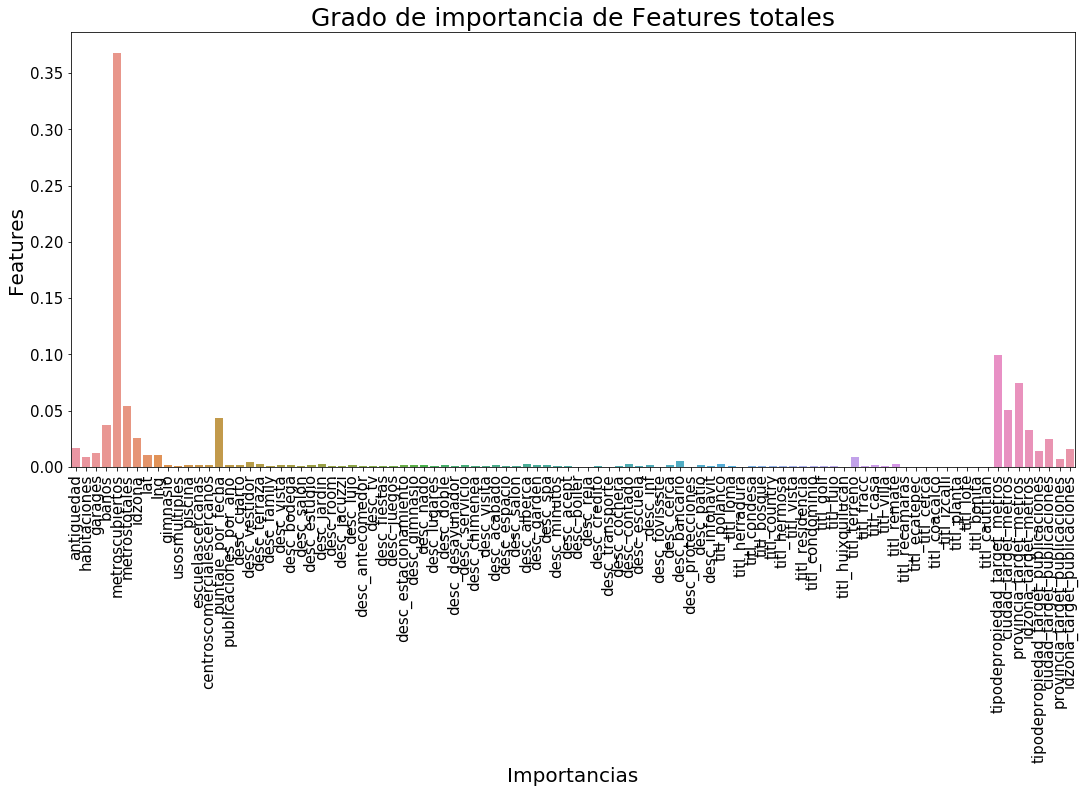

In [0]:
#Muestro la importancia de todos los features
mostrar_importancias(X,Y,RF_model)

In [0]:
#Muestro los 50 mas importantes
mostrar_importancias(X,Y,vr_model, 50)

AttributeError: ignored

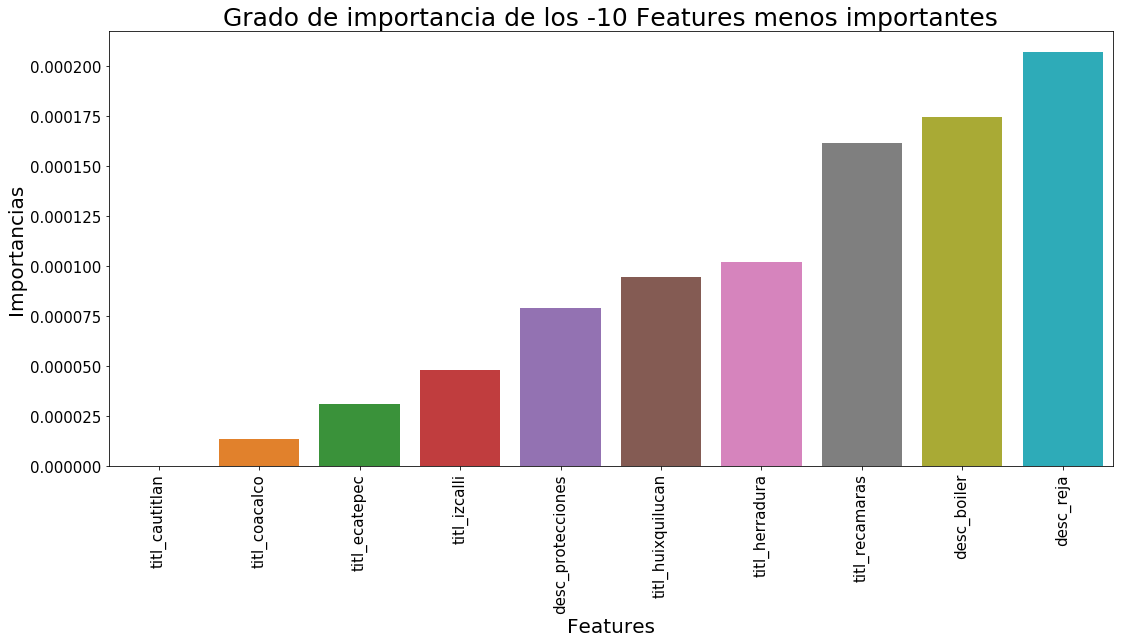

In [0]:
#Muestro los 10 menos importantes
mostrar_importancias(X,Y,RF_model, -10)

### Guardo los features para entrenar los modelos

In [0]:
#me voy a guardar los features para poder tunear los modelos e hiper parámetros
X.to_csv("data/features_train.csv", index = False)
X_test.to_csv("data/features_test.csv", index = False)

# Creo submit

In [0]:
submit1 = crear_submit(RF_model,X, Y, X_test, "RF_versionTP2")
submit1.head()

,id,target
0,4941,5500000.0
1,51775,1006000.0
2,115253,2388000.0
3,299321,1157000.0
4,173570,581000.0


In [0]:
submit1 = crear_submit(vr_model, X, Y, X_test, "VotingRegresso")
submit1.head()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,id,target
0,4941,6354000.0
1,51775,1097000.0
2,115253,2180000.0
3,299321,1295000.0
4,173570,568000.0


In [0]:
submit1 = crear_submit(vr_model, X, Y, X_test, "VotingRegressor")
submit1.head()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:13:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,id,target
0,4941,5758000.0
1,51775,1019000.0
2,115253,2300000.0
3,299321,1095000.0
4,173570,580000.0


In [0]:
X_normalized=normalizar_data(X)
X_test_normalized=normalizar_data(X_test)
